In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import warnings

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_gradient', 
    ['white', '#8d9bff', '#00055c']
)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#8d9bff', '#FF9750', '#FFD900','#7BB5C4', '#9FC1AD', '#D3D3E0'])

In [2]:
latin = pd.read_stata('./datasets/Latinobarometro_2020_Esp_Stata_v1_0.dta', convert_categoricals=False)
gpt = pd.read_csv('./outputs/respuestas_gpt35_turbo.csv')
cohere = pd.read_csv('./outputs/respuestas_cohere.csv')
bard = pd.read_csv('./outputs/respuestas_bard.csv')
categorias = pd.read_csv('./datasets/categorias_agrupadas.csv')

In [3]:
latin = latin[latin['idenpa'] == 32] # Solo Argentina

In [4]:
categorias['pregunta_codigo'] = categorias['Latinobarometro'].apply(lambda x: x.split('-')[0].lower())
categorias.head()

,Latinobarometro,encuesta,categorias,Categorias_2,pregunta_codigo
0,"P11S0037- En general, ¿Diría Ud. que está muy ...",Latinobarometro,democracia - excesos poder ej - presidencialismo,Democracia - Derechos,p11s0037
1,"P11S0038- En general, ¿Diría Ud. que está muy ...",Latinobarometro,economia,Economia,p11s0038
2,P2ST- ¿Diría Ud. que Argentina en el año 2020 ...,Latinobarometro,relaciones internacionales,Relaciones internacionales,p2st
3,P12ST- En términos generales ¿Diría usted que ...,Latinobarometro,democracia - excesos poder ej - presidencialismo,Democracia - Derechos,p12st
4,P4STGBS- ¿Cómo calificaría en general la situa...,Latinobarometro,economia,Economia,p4stgbs


In [5]:
rename_dict =  {'p20stm_b': 'p20st_b',
                'p20stm_c': 'p20st_c',
                'p20stm_d': 'p20st_d',
                'p29n_e': 'p29st_e',
                'p30n': 'p30st_f',
                'p31stm_e': 'p31st_e'
}

In [6]:
latin = latin.rename(columns=rename_dict)

In [7]:
# llmsquestions = list(cohere['Pregunta'].str.lower())
notinlatin = ['p11s0037', 'p11s0038', 'p19st', 'p20st_b', 'p29st_h', 'p23n', 'p48st','p18st']
columns = [item for item in categorias.pregunta_codigo if item not in notinlatin]

In [8]:
latin[columns]

,p2st,p12st,p4stgbs,p5stgbs,p14gbs,p9stgbs,p10stgbs,p17stgbs,p19st_a,p19n_b,...,p47st_h,p47st_i,p47st_j,p47st_k,p47st_l,p47st_m,p49stgbs,p60n_b,p69st,p70st
0,3,1,5,5,3,2,3,2,4,4,...,3,3,4,3,3,4,1,1,1,4
1,1,1,5,5,3,2,1,2,4,4,...,4,1,3,3,1,4,1,1,1,4
2,1,2,5,2,3,2,2,1,3,2,...,2,1,3,2,1,2,2,-5,1,4
3,3,1,5,5,3,2,2,2,4,4,...,2,2,2,2,3,3,1,1,1,4
4,2,-2,4,5,2,2,1,-2,-2,2,...,3,2,2,2,2,2,1,1,-2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2,1,4,4,3,2,-1,-2,3,2,...,2,-2,2,2,2,2,-2,-5,1,4
1196,-1,-2,4,4,3,-2,-1,1,-1,-2,...,3,2,4,2,2,3,1,-5,1,3
1197,2,1,5,5,4,2,3,1,4,4,...,4,3,4,4,4,4,2,1,1,4
1198,3,1,4,5,3,2,3,2,4,3,...,1,1,1,1,1,1,2,1,1,4


In [9]:
# Reemplazo "Ninguna", "No sabe", y "No contesta" en ideo por NA
latin.loc[:, 'p18st'] = latin['p18st'].replace([97, -1, -2], None)

# Reemplazo "No sabe" y "No contesta" en interes politica por NA
latin.loc[:, 'p46stgbs'] = latin['p46stgbs'].replace([-1, -2], None)

# No especificaste el reemplazo para 's13', pero si fuera similar a los anteriores, sería así:
latin.loc[:, 's13'] = latin['s13'].replace([-5], None)

df_clean = latin.dropna(subset=['p18st','p46stgbs','s13'])
df_clean.loc[:, 'p18st'] = df_clean['p18st'].astype(float)
df_clean.loc[:, 'p46stgbs'] = df_clean['p46stgbs'].astype(float)
df_clean.loc[:, 's13'] = df_clean['s13'].astype(float)

In [10]:
corr_matrix = df_clean.corr()
demographics = ['edad','sexo', 'p18st' ,'s16','s13','s17','p46stgbs']

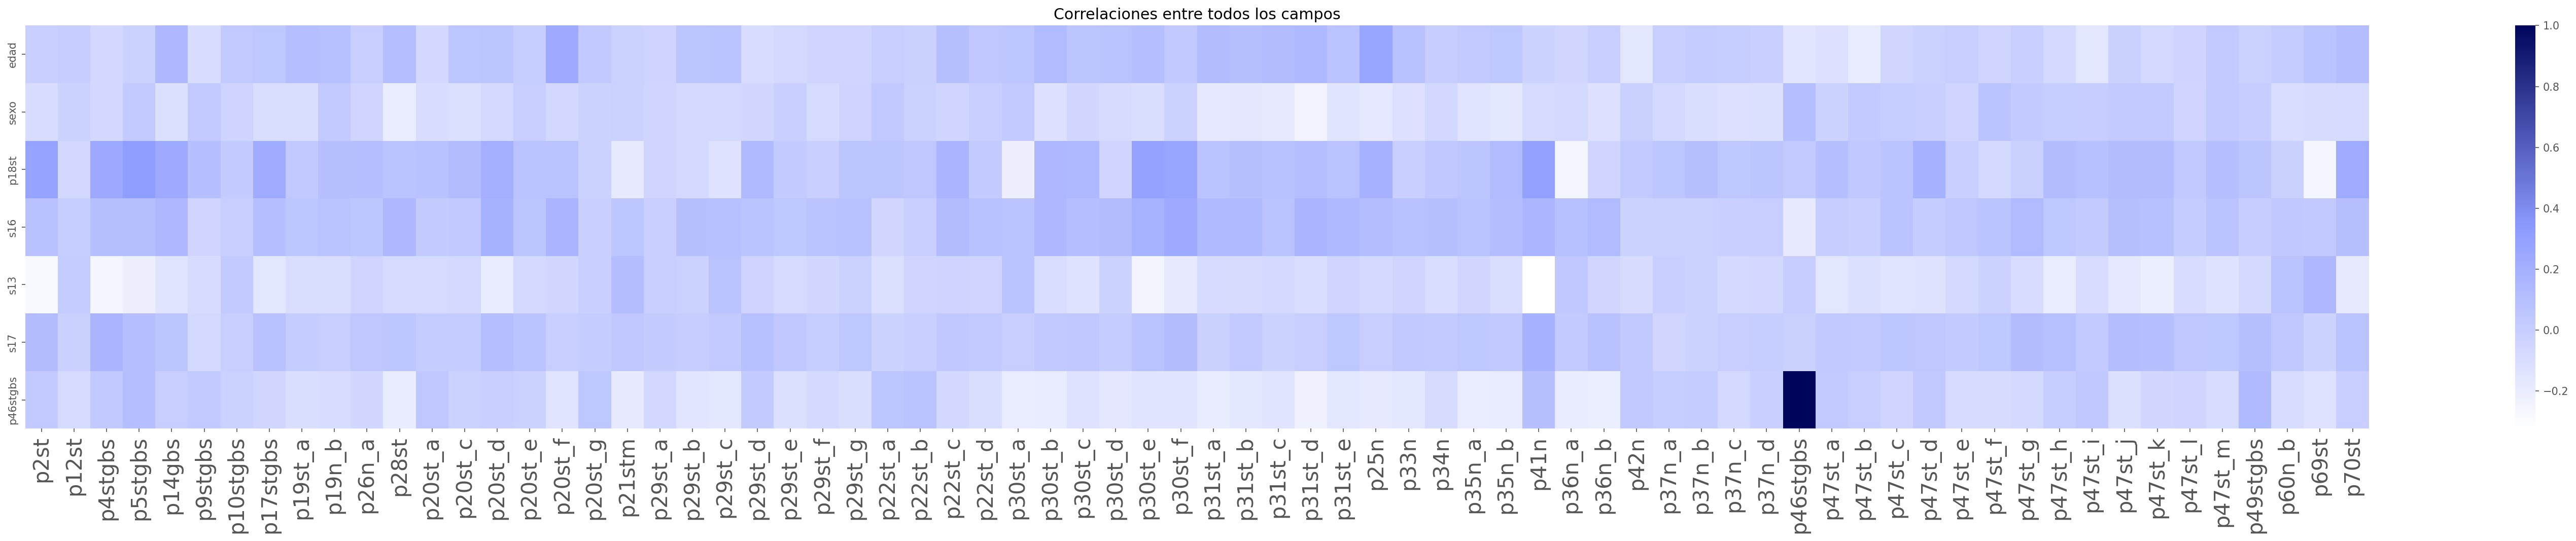

In [11]:
plt.figure(figsize=(70, 10), dpi=150)
cor = corr_matrix.loc[demographics, columns]
sns.heatmap(cor,  cmap=custom_cmap)
plt.title("Correlaciones entre todos los campos")
plt.subplots_adjust(bottom=0.35)
plt.subplots_adjust(left=0.35)
plt.xticks(fontsize=20)
plt.savefig('./outputs/correlaciones.png')
plt.show()

In [12]:
# Crea un StataReader para leer los metadatos
reader = pd.io.stata.StataReader('./datasets/Latinobarometro_2020_Esp_Stata_v1_0.dta')

In [13]:
import pickle
with open(r"./datasets/respuestas.pickle", "rb") as input_file:
    respuestas = pickle.load(input_file)
with open(r"./datasets/preguntas_seleccionadas.pickle", "rb") as input_file:
    preguntas_seleccionadas = pickle.load(input_file)

In [14]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Me aseguro de que 'X' e 'y' sean numericas
X = df_clean[columns].apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(df_clean['s16'], errors='coerce')
df_clean = df_clean.dropna()

# Añado una constante a las variables independientes
X = sm.add_constant(X)

# Ajustar el modelo
model = sm.OLS(y, X).fit()

# Imprimir los resultados
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    s16   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2.184
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           3.12e-07
Time:                        11:03:07   Log-Likelihood:                -1728.2
No. Observations:                 739   AIC:                             3602.
Df Residuals:                     666   BIC:                             3939.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4707      0.915     12.542      0.0

- p29st_c
- p22st_c
- p30st_a
- p30st_e
- p25n (da mas de izq)
- p36n_a
- p47st_h (da mas de izq)
- p69st

In [15]:
code = 'p14gbs'
print(preguntas_seleccionadas[code.upper()])
question_convert = reader.value_labels()[code.upper()]
print('¿Que contesto GPT? ',question_convert[gpt[gpt['Pregunta']==code.upper()]['Respuesta'].values[0]])
question_convert = reader.value_labels()[code.upper()]
print('¿Que contesto Bard? ',question_convert[bard[bard['Pregunta']==code.upper()]['Respuesta'].values[0]])
question_convert = reader.value_labels()[code.upper()]
print('¿Que contesto Cohere? ',question_convert[cohere[cohere['Pregunta']==code.upper()]['Respuesta'].values[0]])



¿Cómo diría Ud. que es la democracia en Argentina?
¿Que contesto GPT?  No contesta
¿Que contesto Bard?  Una democracia con pequeÃ±os problemas
¿Que contesto Cohere?  Una democracia plena


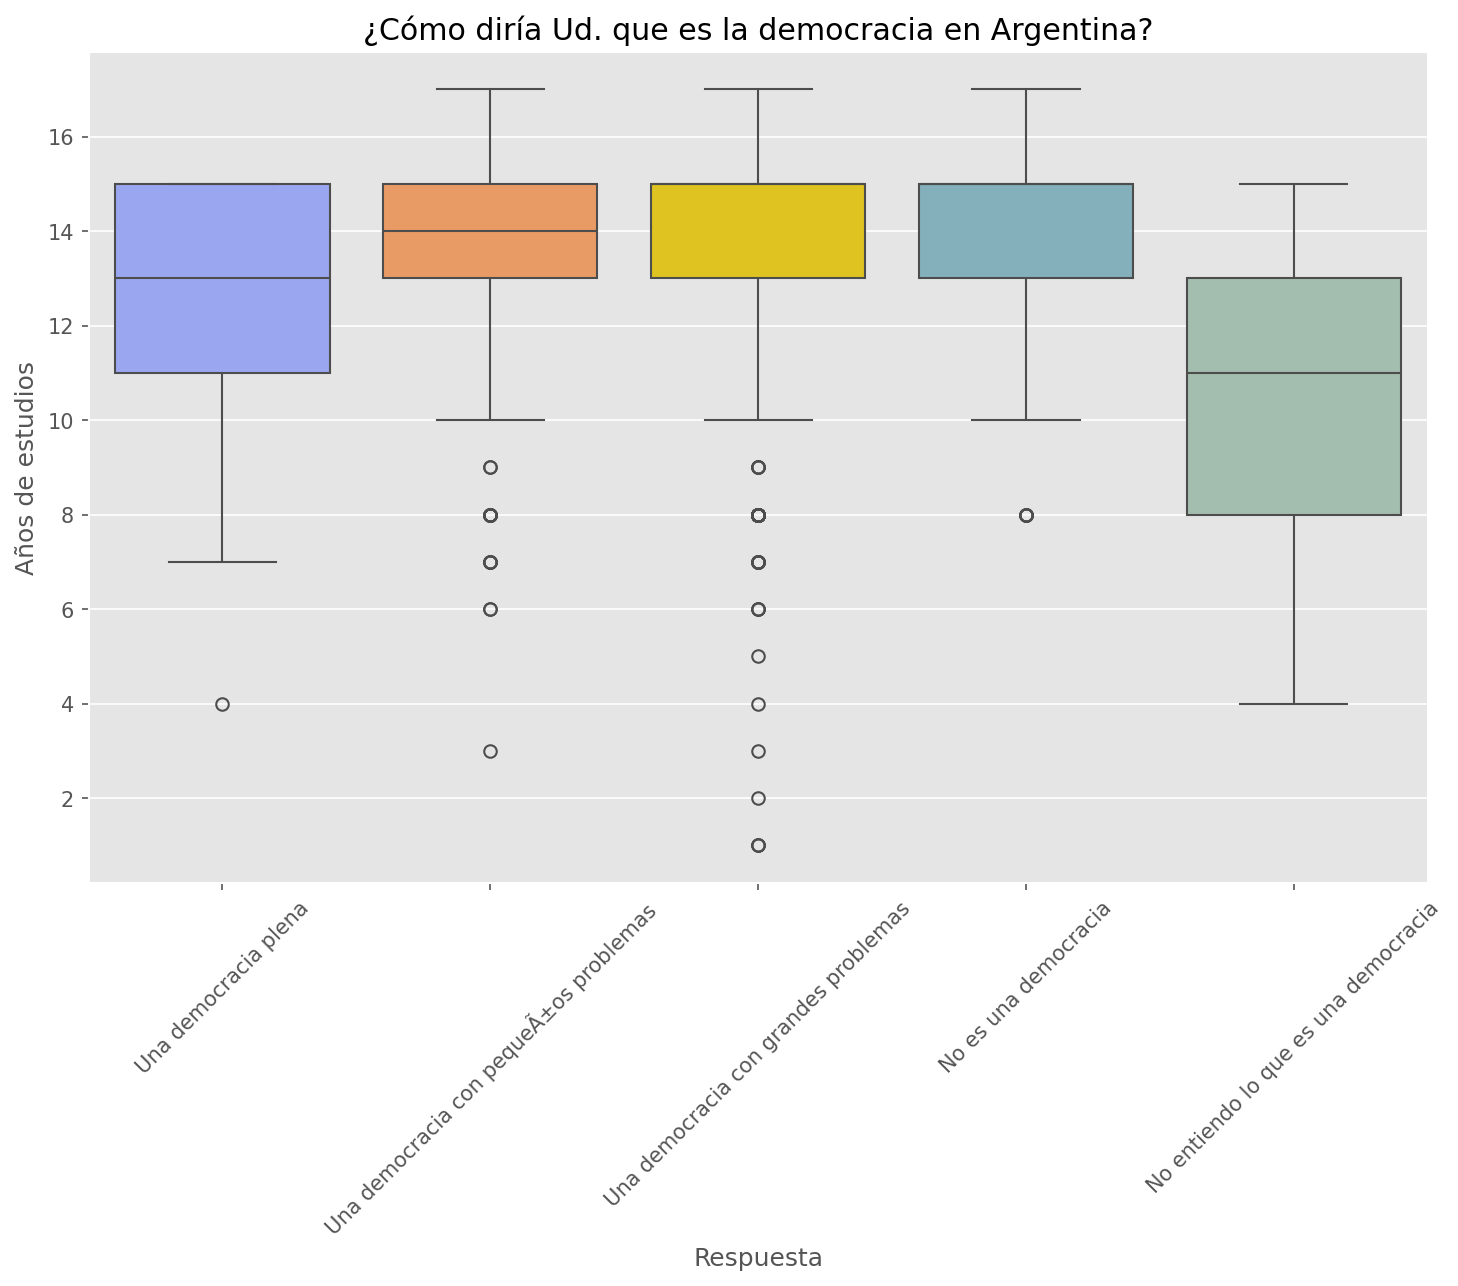

In [16]:
question_convert = reader.value_labels()[code.upper()]
df_clean[code+'text'] = df_clean[code].apply(lambda x: question_convert[x])
titulo = preguntas_seleccionadas[code.upper()]
responses=list(reader.value_labels()[code.upper()].values())
notinlatin = ['No sabe / No contesta',
 'No preguntada',
 'No aplicable','No contesta','No sabe']
order = [item for item in responses if item not in notinlatin]

custom_colors = ['#8d9bff', '#FF9750', '#FFD900','#7BB5C4', '#9FC1AD', '#D3D3E0']
palette = dict(zip(order, custom_colors))

plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=150)
sns.boxplot(x=code+'text', y="s16", data=df_clean,order=order, palette=palette)
plt.ylabel("Años de estudios")
plt.xlabel("Respuesta")
plt.title(titulo)
plt.xticks(rotation=45)
#labels = ['Muy Politizado', 1.5, 2. , 2.5, 3. , 3.5, 'No Politizado']
#plt.ylim(1, 4)
#x_ticks_locs = plt.yticks()[0]
#plt.yticks(x_ticks_locs, labels)
plt.savefig('./outputs/boxplot_democracia_argentina.png', bbox_inches='tight')
plt.show() 

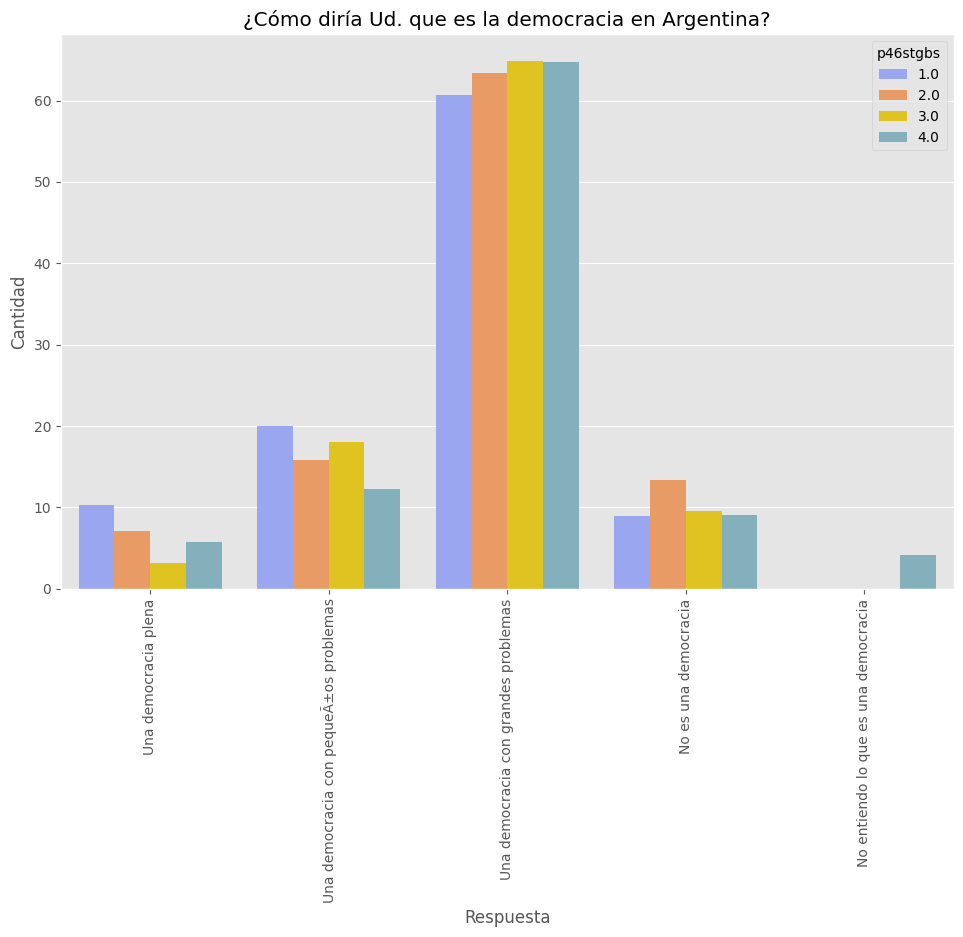

In [17]:

sns.set_palette('pastel')
question_convert = reader.value_labels()[code.upper()]
df_clean[code+'text'] = df_clean[code].apply(lambda x: question_convert[x])
titulo = preguntas_seleccionadas[code.upper()]
responses=list(reader.value_labels()[code.upper()].values())
notinlatin = ['No sabe / No contesta',
 'No preguntada',
 'No aplicable','No contesta','No sabe']
order = [item for item in responses if item not in notinlatin]
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=100)
occupation_counts = (df_clean.groupby(['p46stgbs'])[code+'text']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(code+'text'))
p = sns.barplot(x=code+'text', y="percentage", hue="p46stgbs", data=occupation_counts,order=order, palette=['#8d9bff', '#FF9750', '#FFD900','#7BB5C4'])
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
plt.ylabel("Cantidad")
plt.xlabel("Respuesta")
plt.title(titulo)
plt.xticks(rotation=90)
#plt.subplots_adjust(bottom=0.45)
plt.savefig('./outputs/barchart_democracia_argentina.png', bbox_inches='tight')
plt.show()

In [18]:
df_clean['sexo_text'] =df_clean['sexo'].apply(lambda x: 'Hombre' if x == 1 else 'Mujer')

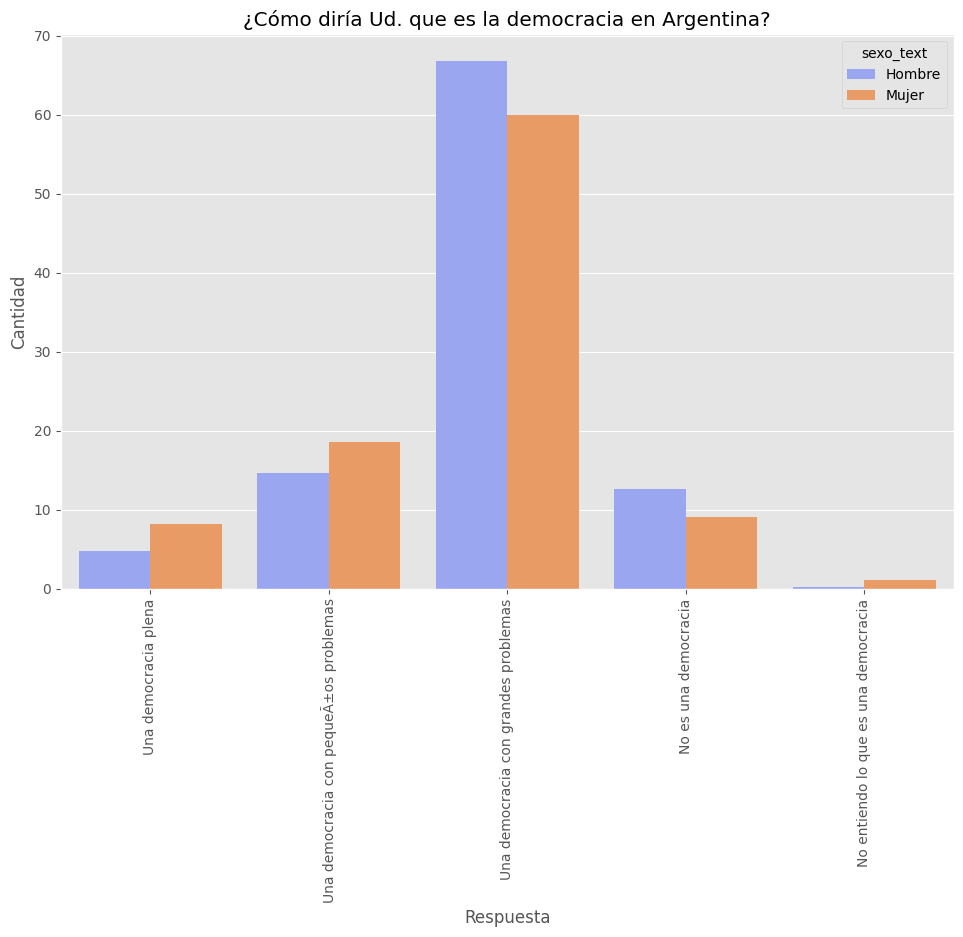

In [19]:
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=100)
occupation_counts = (df_clean.groupby(['sexo_text'])[code+'text']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(code+'text'))
p = sns.barplot(x=code+'text', y="percentage", hue="sexo_text", data=occupation_counts,order=order, palette=['#8d9bff', '#FF9750'])
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
plt.ylabel("Cantidad")
plt.xlabel("Respuesta")
plt.title(titulo)
plt.xticks(rotation=90)
#plt.subplots_adjust(bottom=0.45)
plt.savefig('./outputs/barchart_democracia_argentina_genero.png', bbox_inches='tight')
plt.show()

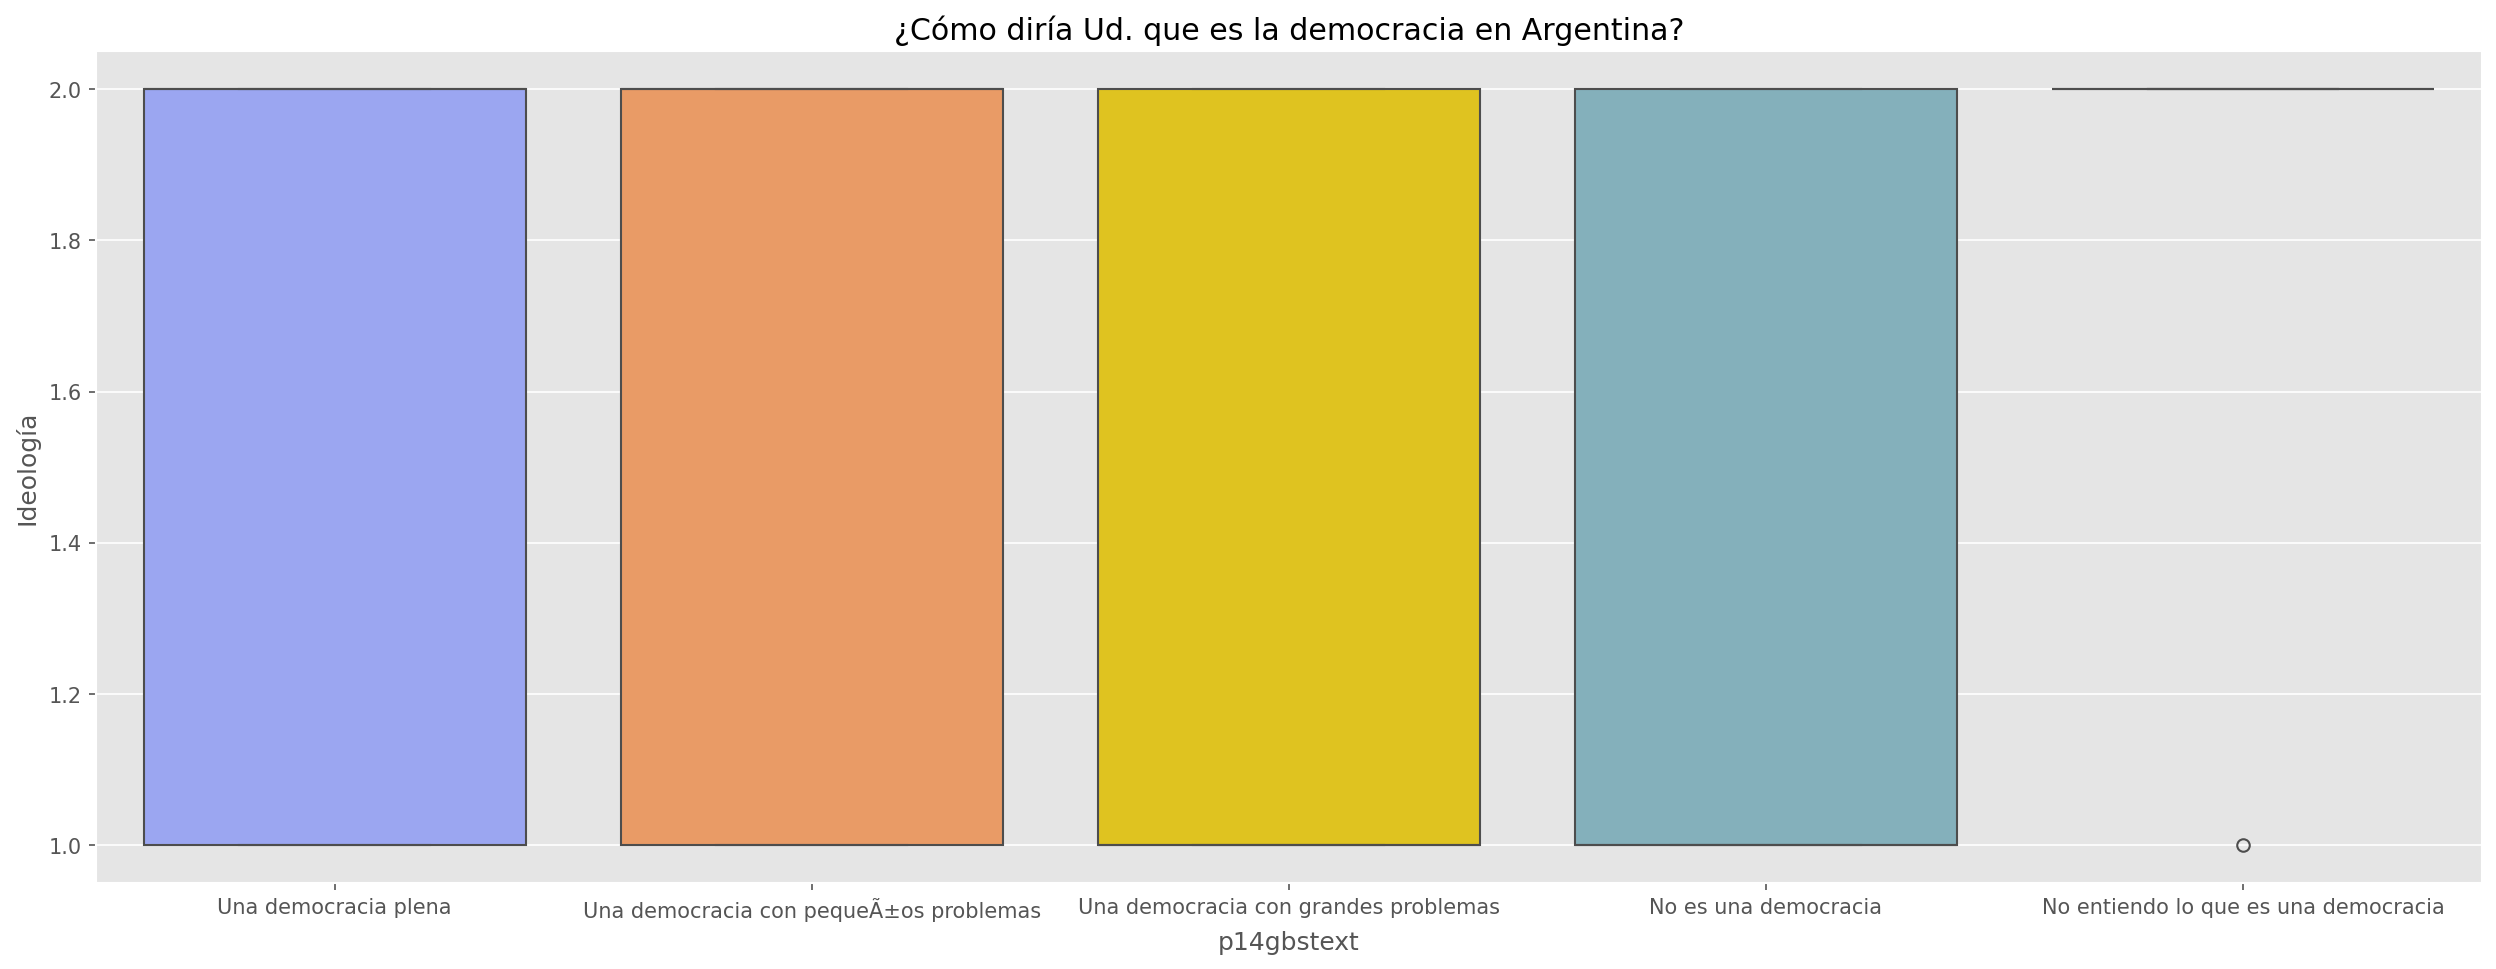

In [20]:
plt.figure(figsize=(11.4 * 1.8, 4.8 * 1.5), dpi=150)
sns.boxplot(x=code+'text', y="sexo", data=df_clean,order=order, palette=['#8d9bff', '#FF9750', '#FFD900','#7BB5C4', '#9FC1AD', '#D3D3E0'])
plt.ylabel("Ideología")
#plt.xlabel("Provincia")
plt.title(titulo)

plt.savefig('./outputs/reduccion_boxplots_democracia_argentina.png')
plt.show() 

In [21]:
question_convert = reader.value_labels()['p41n'.upper()]
df_clean['p41n_text'] = df_clean['p41n'].apply(lambda x: question_convert[x])

# Ideología

## Manejo de la pandemia

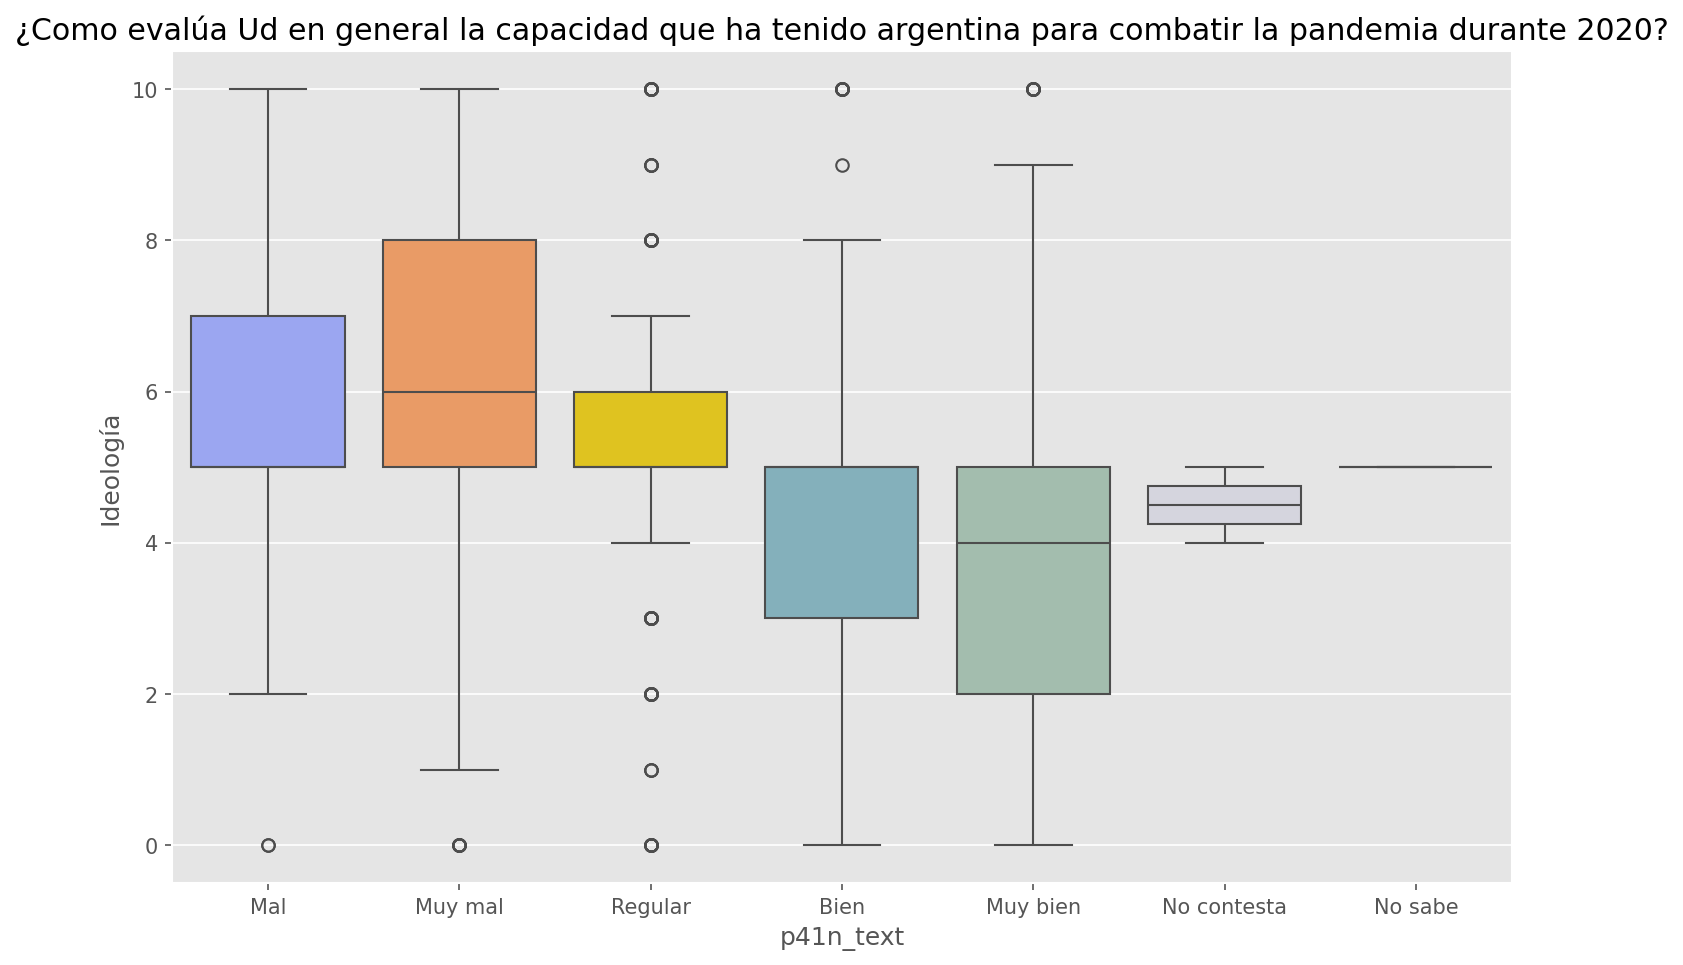

In [22]:
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=150)
sns.boxplot(x="p41n_text", y="p18st", data=df_clean, palette=custom_colors)
plt.ylabel("Ideología")
#plt.xlabel("Provincia")
plt.title('¿Como evalúa Ud en general la capacidad que ha tenido argentina para combatir la pandemia durante 2020?')

plt.savefig('./outputs/boxplot_pandemia.png')
plt.show() 

In [23]:
def leaning(x):
    if(x < 4):
        return('Izquierda')
    elif(x > 4):
        return('Derecha')
    else:
        return('Centro')

In [24]:
df_clean['Ideologia'] = df_clean['p18st'].apply(lambda x: leaning(x))

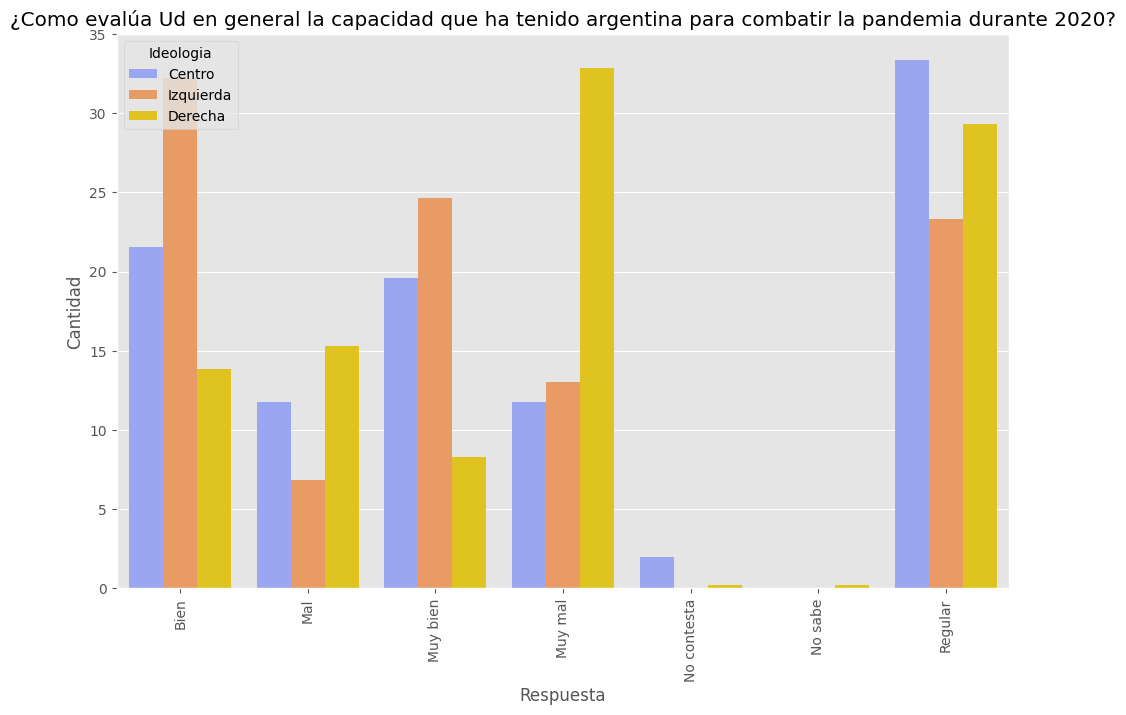

In [25]:
sns.set_palette('pastel')
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=100)
occupation_counts = (df_clean.groupby(['Ideologia'])['p41n_text']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('p41n_text'))
p = sns.barplot(x="p41n_text", y="percentage", hue="Ideologia", data=occupation_counts, palette=custom_colors)
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
plt.ylabel("Cantidad")
plt.xlabel("Respuesta")
plt.title('¿Como evalúa Ud en general la capacidad que ha tenido argentina para combatir la pandemia durante 2020?')
plt.xticks(rotation=90)
#plt.subplots_adjust(bottom=0.45)
plt.savefig('./outputs/barchart_manejo_pandemia.png')
plt.show()

In [26]:
print('¿Que contesto Bard? ',question_convert[bard[bard['Pregunta']=='p41n'.upper()]['Respuesta'].values[0]])

¿Que contesto Bard?  Regular


In [27]:
print('¿Que contesto GPT? ',question_convert[gpt[gpt['Pregunta']=='p46stgbs'.upper()]['Respuesta'].values[0]])

¿Que contesto GPT?  No contesta


# Situación 2020

In [28]:
question_convert = reader.value_labels()['p5stgbs'.upper()]
df_clean['p5stgbs_text'] = df_clean['p5stgbs'].apply(lambda x: question_convert[x])

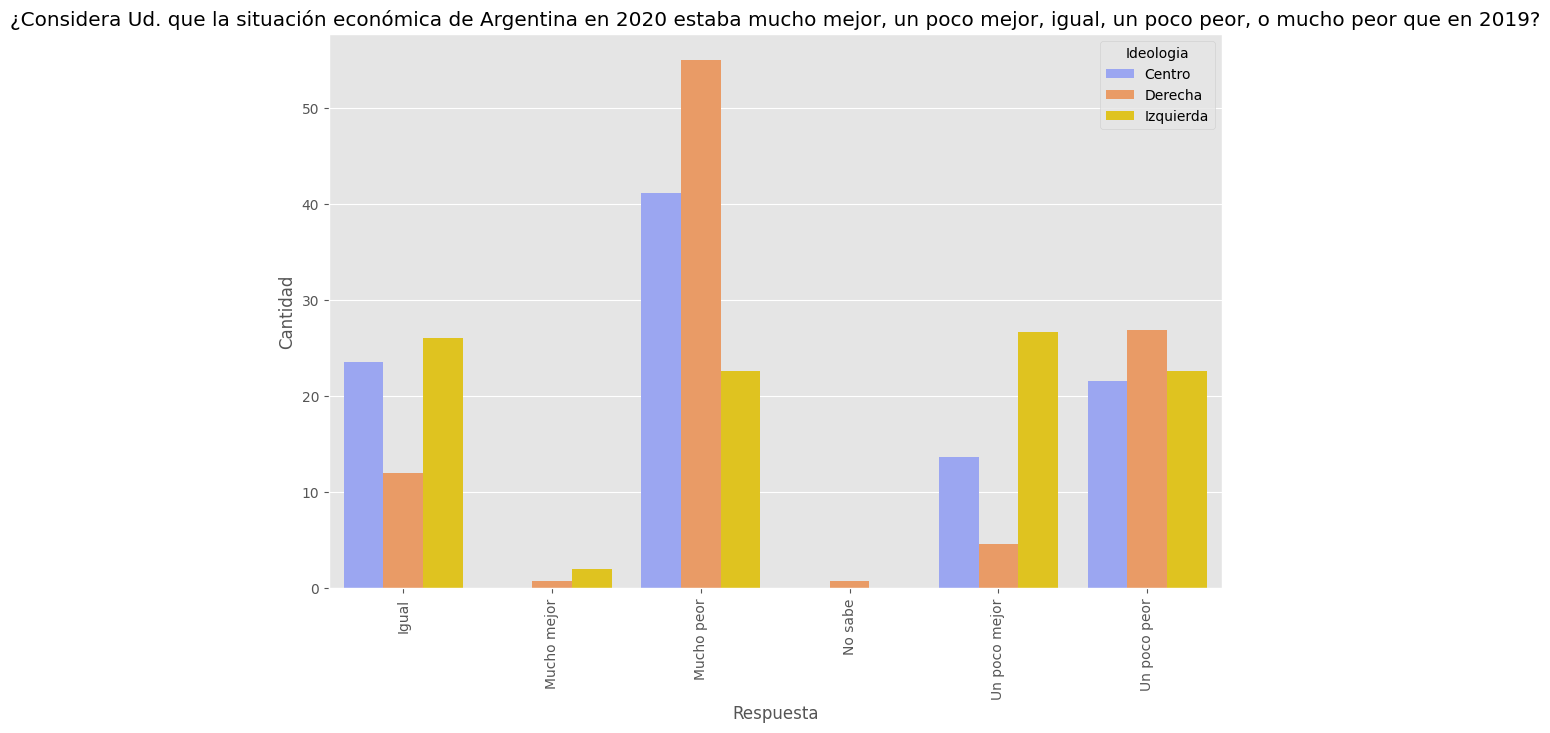

In [29]:
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=100)
occupation_counts = (df_clean.groupby(['Ideologia'])['p5stgbs_text']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('p5stgbs_text'))
p = sns.barplot(x="p5stgbs_text", y="percentage", hue="Ideologia", data=occupation_counts, palette=custom_colors)
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
plt.ylabel("Cantidad")
plt.xlabel("Respuesta")
plt.title('¿Considera Ud. que la situación económica de Argentina en 2020 estaba mucho mejor, un poco mejor, igual, un poco peor, o mucho peor que en 2019?')
plt.xticks(rotation=90)
#plt.subplots_adjust(bottom=0.45)
plt.savefig('./outputs/situacion2020.png', bbox_inches='tight')
plt.show()

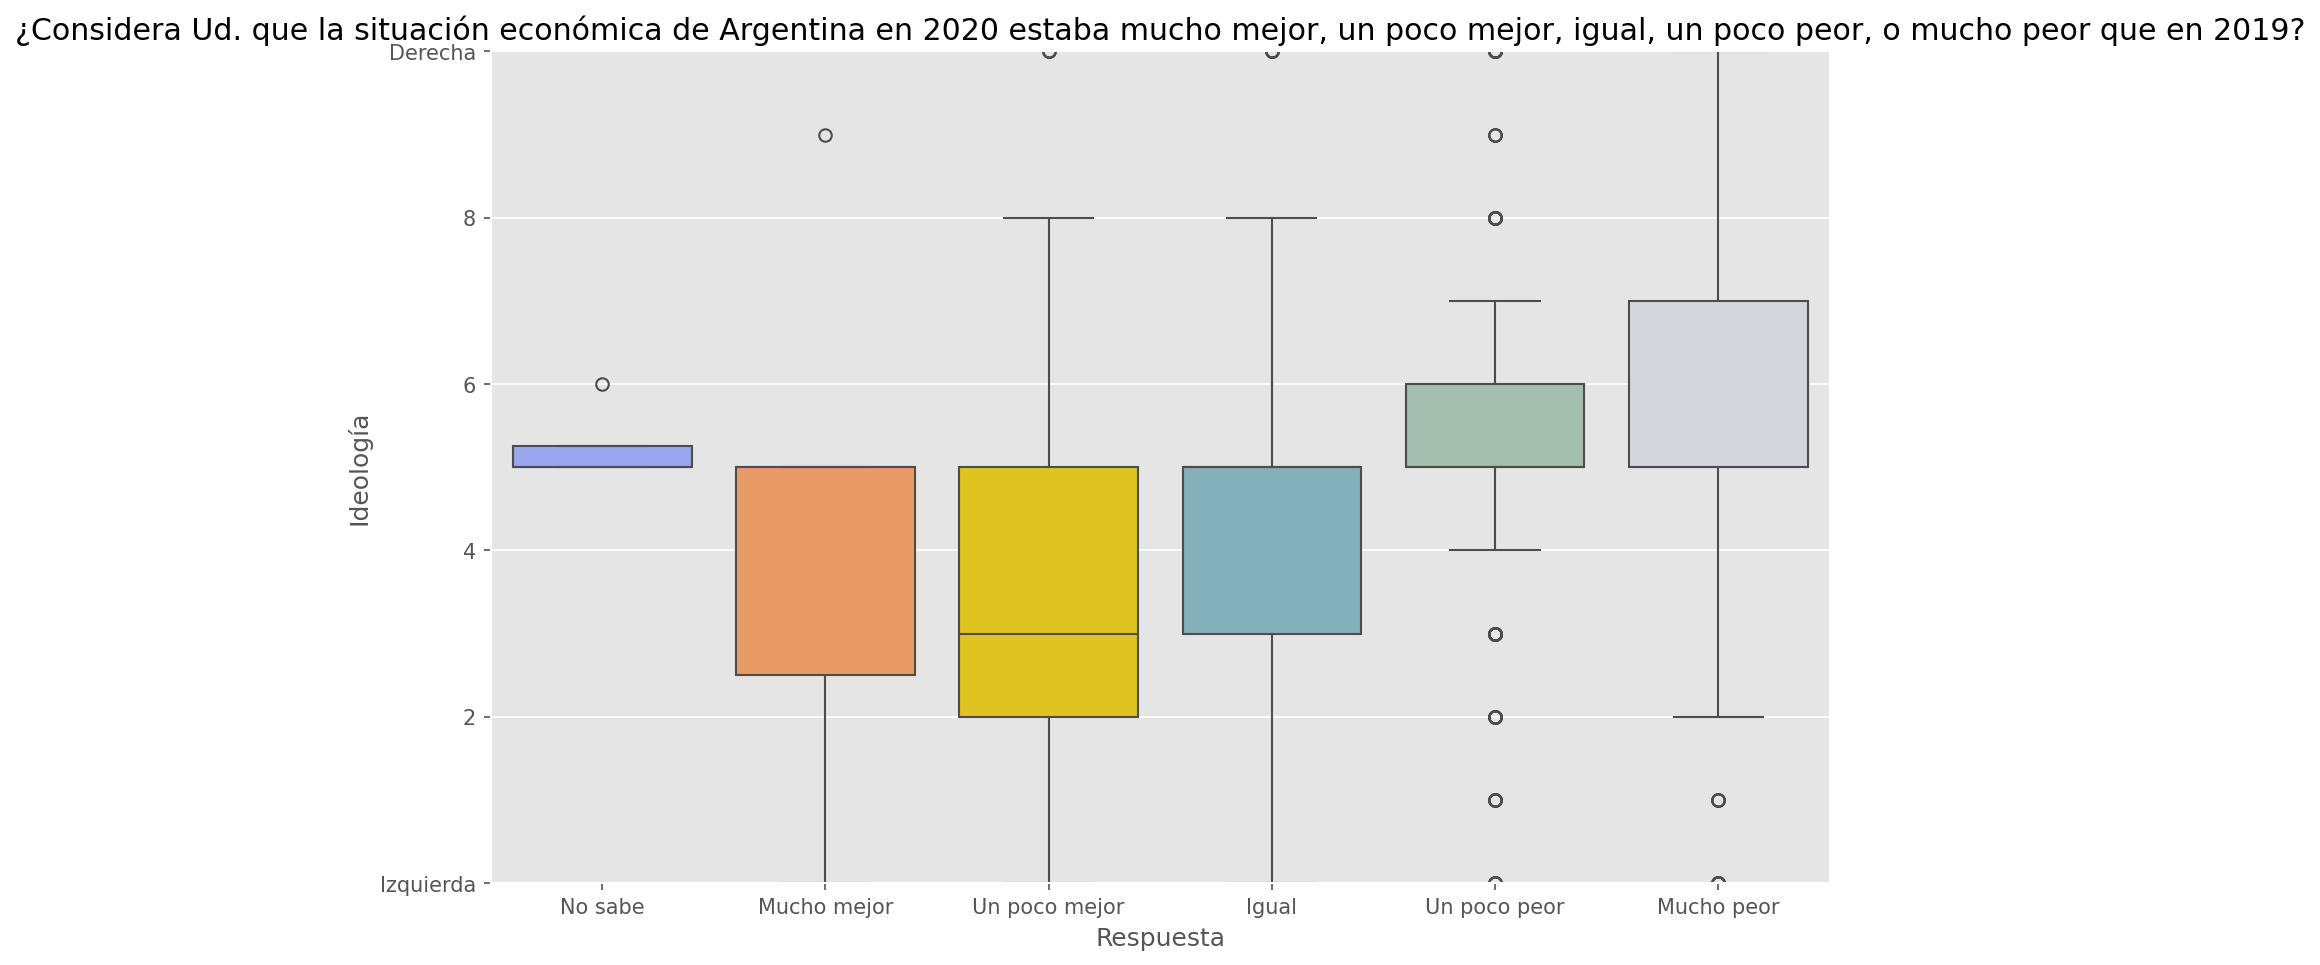

In [30]:
responses = list(reader.value_labels()['p5stgbs'.upper()].values())
notinlatin = ['No sabe / No contesta',
 'No preguntada',
 'No aplicable','No contesta']
order = [item for item in responses if item not in notinlatin]

plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=150)
sns.boxplot(x="p5stgbs_text", y="p18st", data=df_clean,order=order, palette=custom_colors)
plt.ylabel("Ideología")
plt.xlabel("Respuesta")
plt.title('¿Considera Ud. que la situación económica de Argentina en 2020 estaba mucho mejor, un poco mejor, igual, un poco peor, o mucho peor que en 2019?')
labels = ['Izquierda', 2, 4,6,8, 'Derecha']
plt.ylim(0, 10)
x_ticks_locs = plt.yticks()[0]
plt.yticks(x_ticks_locs, labels)
plt.savefig('./outputs/boxplot_situacion_2020.png', bbox_inches='tight')
plt.show() 

In [31]:
print('¿Que contesto Bard? ',question_convert[bard[bard['Pregunta']=='p5stgbs'.upper()]['Respuesta'].values[0]])
print('¿Que contesto GPT? ',question_convert[gpt[gpt['Pregunta']=='p5stgbs'.upper()]['Respuesta'].values[0]])

¿Que contesto Bard?  Mucho peor
¿Que contesto GPT?  Mucho peor


# Cuba

In [32]:
question_convert = reader.value_labels()['p30st_e'.upper()]
df_clean['p30st_e_text'] = df_clean['p30st_e'].apply(lambda x: question_convert[x])

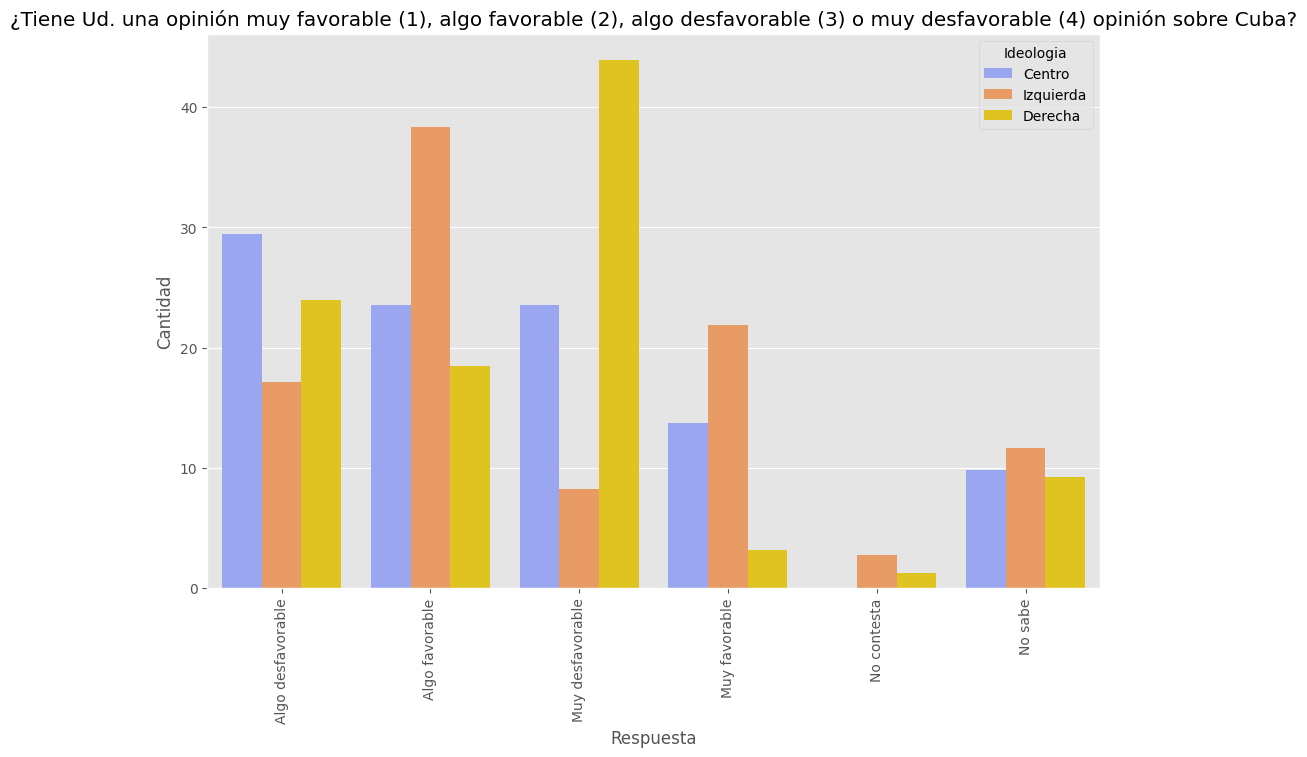

In [33]:
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=100)
occupation_counts = (df_clean.groupby(['Ideologia'])['p30st_e_text']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('p30st_e_text'))
p = sns.barplot(x="p30st_e_text", y="percentage", hue="Ideologia", data=occupation_counts, palette=custom_colors)
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
plt.ylabel("Cantidad")
plt.xlabel("Respuesta")
plt.title('¿Tiene Ud. una opinión muy favorable (1), algo favorable (2), algo desfavorable (3) o muy desfavorable (4) opinión sobre Cuba?')
plt.xticks(rotation=90)
#plt.subplots_adjust(bottom=0.45)
plt.savefig('./outputs/barchart_cuba.png')
plt.show()

In [34]:
print('¿Que contesto Bard? ',question_convert[bard[bard['Pregunta']=='p30st_e'.upper()]['Respuesta'].values[0]])
print('¿Que contesto GPT? ',question_convert[gpt[gpt['Pregunta']=='p30st_e'.upper()]['Respuesta'].values[0]])

¿Que contesto Bard?  Algo favorable
¿Que contesto GPT?  No contesta


# Controlar medios

In [35]:
question_convert = reader.value_labels()['P20STM_D'.upper()]
df_clean['p20st_d_text'] = df_clean['p20st_d'].apply(lambda x: question_convert[x])

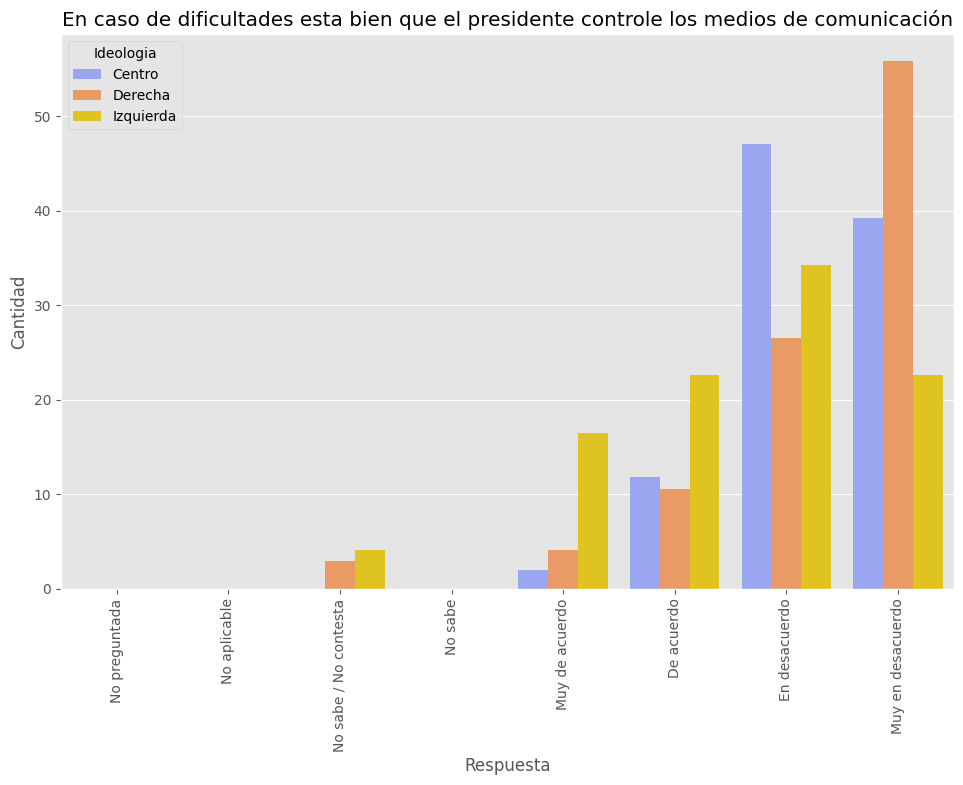

In [36]:
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=100)
occupation_counts = (df_clean.groupby(['Ideologia'])['p20st_d_text']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('p20st_d_text'))
p = sns.barplot(x="p20st_d_text", y="percentage", hue="Ideologia", data=occupation_counts,order=list(reader.value_labels()['P20STM_D'.upper()].values()), palette=custom_colors)
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
plt.ylabel("Cantidad")
plt.xlabel("Respuesta")
plt.title('En caso de dificultades esta bien que el presidente controle los medios de comunicación')
plt.xticks(rotation=90)
#plt.subplots_adjust(bottom=0.45)
plt.savefig('./outputs/barchart_controlar_medios.png', bbox_inches='tight')
plt.show()

In [37]:
print('¿Que contesto Bard? ',question_convert[bard[bard['Pregunta']=='p5stgbs'.upper()]['Respuesta'].values[0]-1])
print('¿Que contesto GPT? ',question_convert[gpt[gpt['Pregunta']=='p20st_d'.upper()]['Respuesta'].values[0]])

¿Que contesto Bard?  Muy en desacuerdo
¿Que contesto GPT?  En desacuerdo


# Reducir corrupción

In [38]:
question_convert = reader.value_labels()['p70st'.upper()]
df_clean['p70st_text'] = df_clean['p70st'].apply(lambda x: question_convert[x])

In [39]:
responses = list(reader.value_labels()['p70st'.upper()].values())
notinlatin = ['No sabe / No contesta',
 'No preguntada',
 'No aplicable']
order = [item for item in responses if item not in notinlatin]


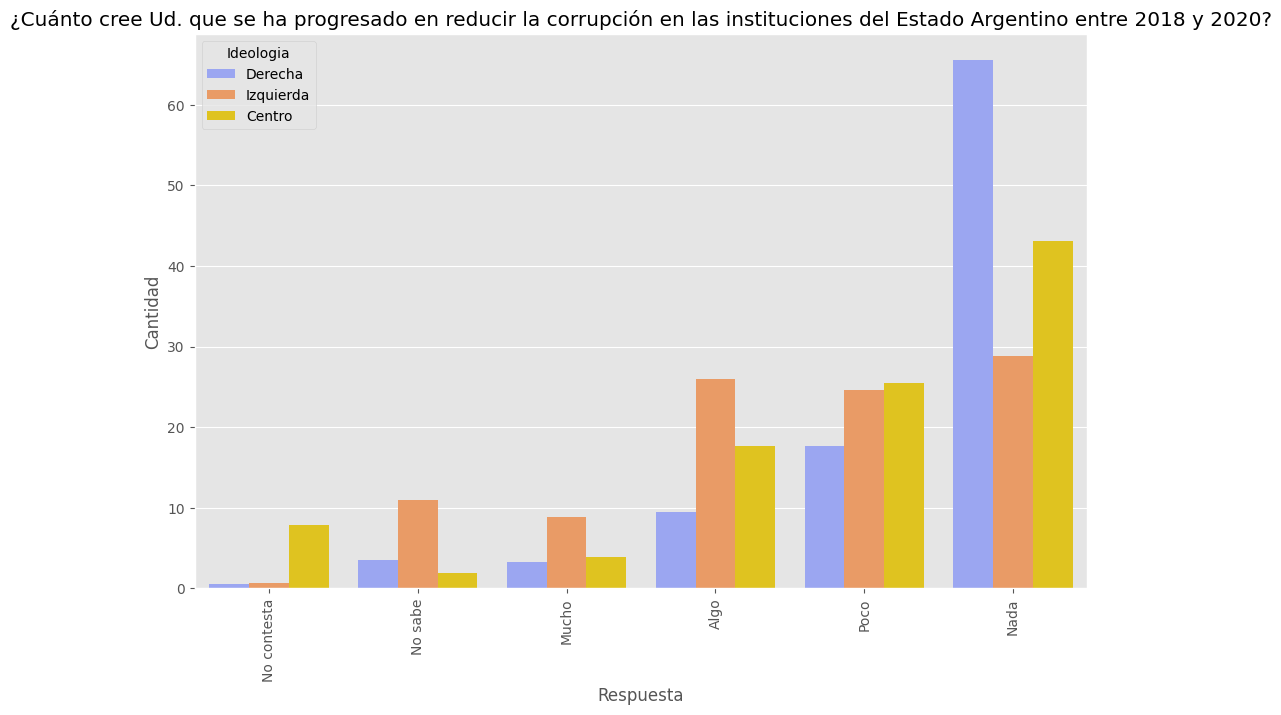

In [40]:
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=100)
occupation_counts = (df_clean.groupby(['Ideologia'])['p70st_text']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('p70st_text'))
p = sns.barplot(x="p70st_text", y="percentage", hue="Ideologia", data=occupation_counts,order=order,palette=custom_colors)
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
plt.ylabel("Cantidad")
plt.xlabel("Respuesta")
plt.title('¿Cuánto cree Ud. que se ha progresado en reducir la corrupción en las instituciones del Estado Argentino entre 2018 y 2020?')
plt.xticks(rotation=90)
#plt.subplots_adjust(bottom=0.45)
plt.savefig('./outputs/reduccion_corrupcion.png', bbox_inches='tight')
plt.show()

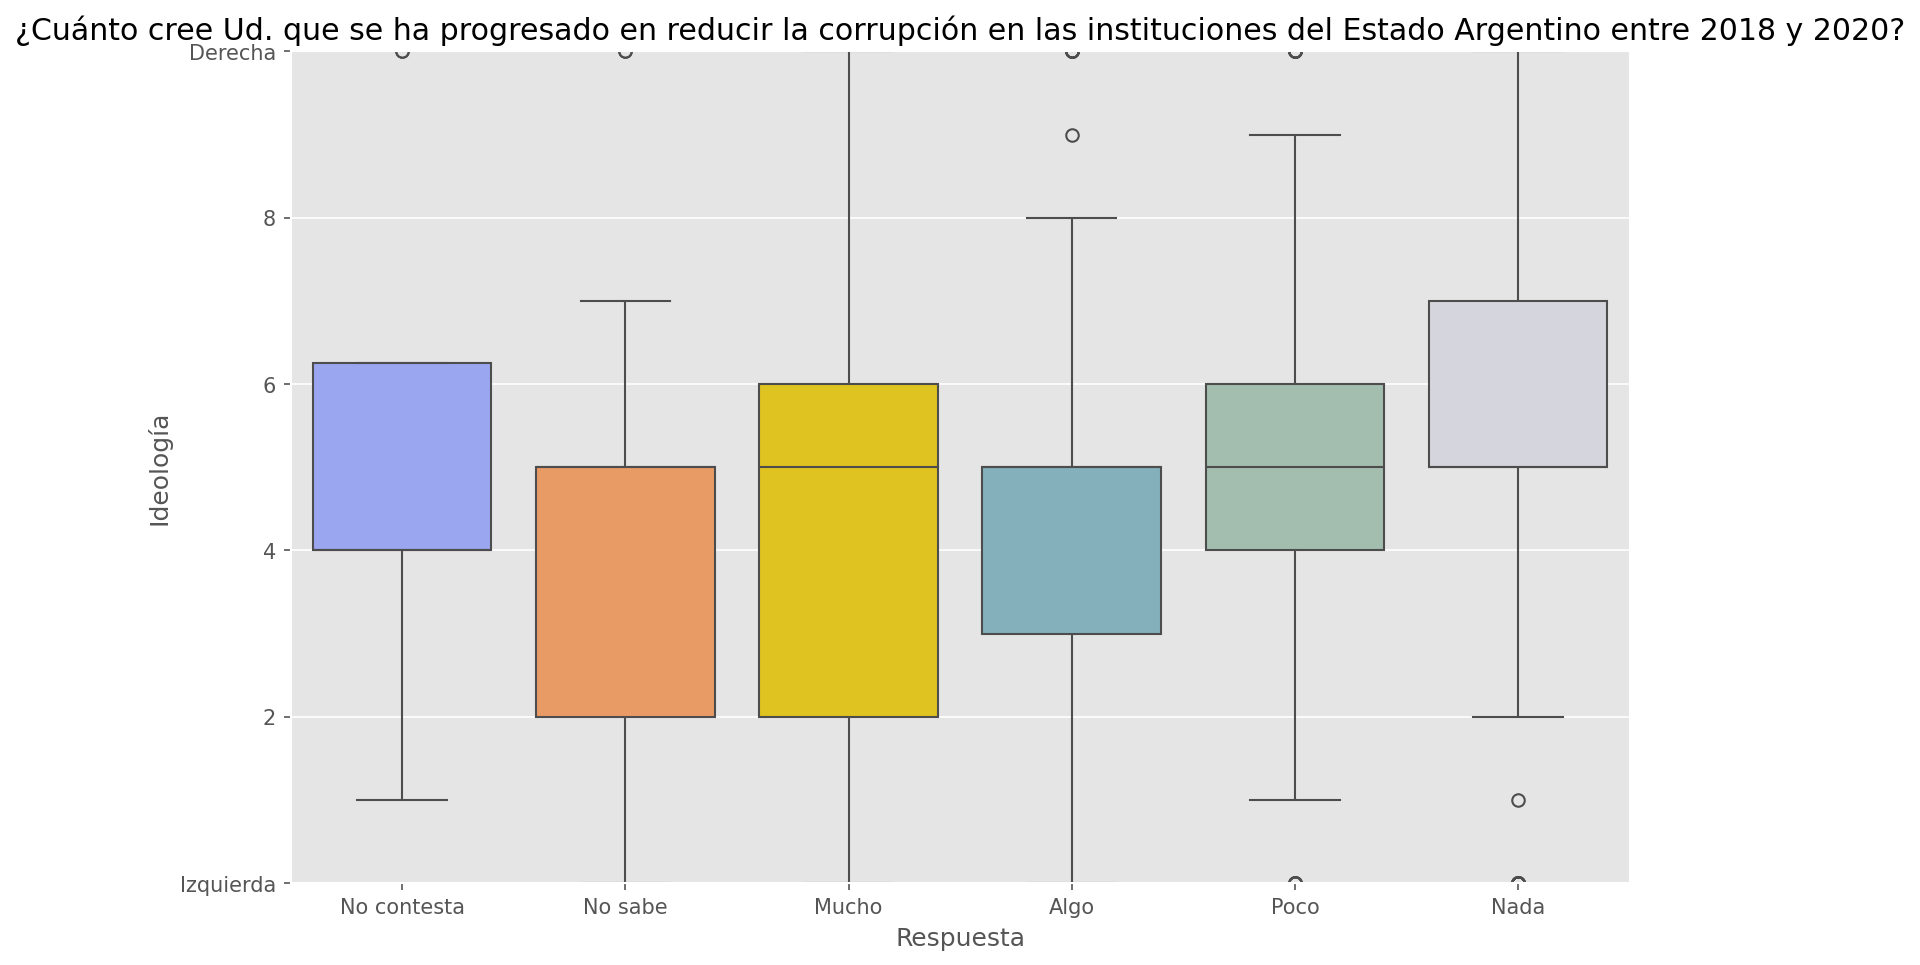

In [41]:
responses = list(reader.value_labels()['p70st'.upper()].values())
notinlatin = ['No sabe / No contesta',
 'No preguntada',
 'No aplicable']
order = [item for item in responses if item not in notinlatin]

plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=150)
sns.boxplot(x="p70st_text", y="p18st", data=df_clean,order=order,palette=custom_colors)
plt.ylabel("Ideología")
plt.xlabel("Respuesta")
plt.title('¿Cuánto cree Ud. que se ha progresado en reducir la corrupción en las instituciones del Estado Argentino entre 2018 y 2020?')
labels = ['Izquierda', 2, 4,6,8, 'Derecha']
plt.ylim(0, 10)
x_ticks_locs = plt.yticks()[0]
plt.yticks(x_ticks_locs, labels)
plt.savefig('./outputs/boxplot_reducir_corrupcion.png')
plt.show() 

In [42]:
print('¿Que contesto Bard? ',question_convert[bard[bard['Pregunta']=='p5stgbs'.upper()]['Respuesta'].values[0]-1])
print('¿Que contesto GPT? ',question_convert[gpt[gpt['Pregunta']=='p70st'.upper()]['Respuesta'].values[0]])

¿Que contesto Bard?  Nada
¿Que contesto GPT?  Poco


# Integración

In [43]:
question_convert = reader.value_labels()['p25n'.upper()]
df_clean['p25n_text'] = df_clean['p25n'].apply(lambda x: question_convert[x])

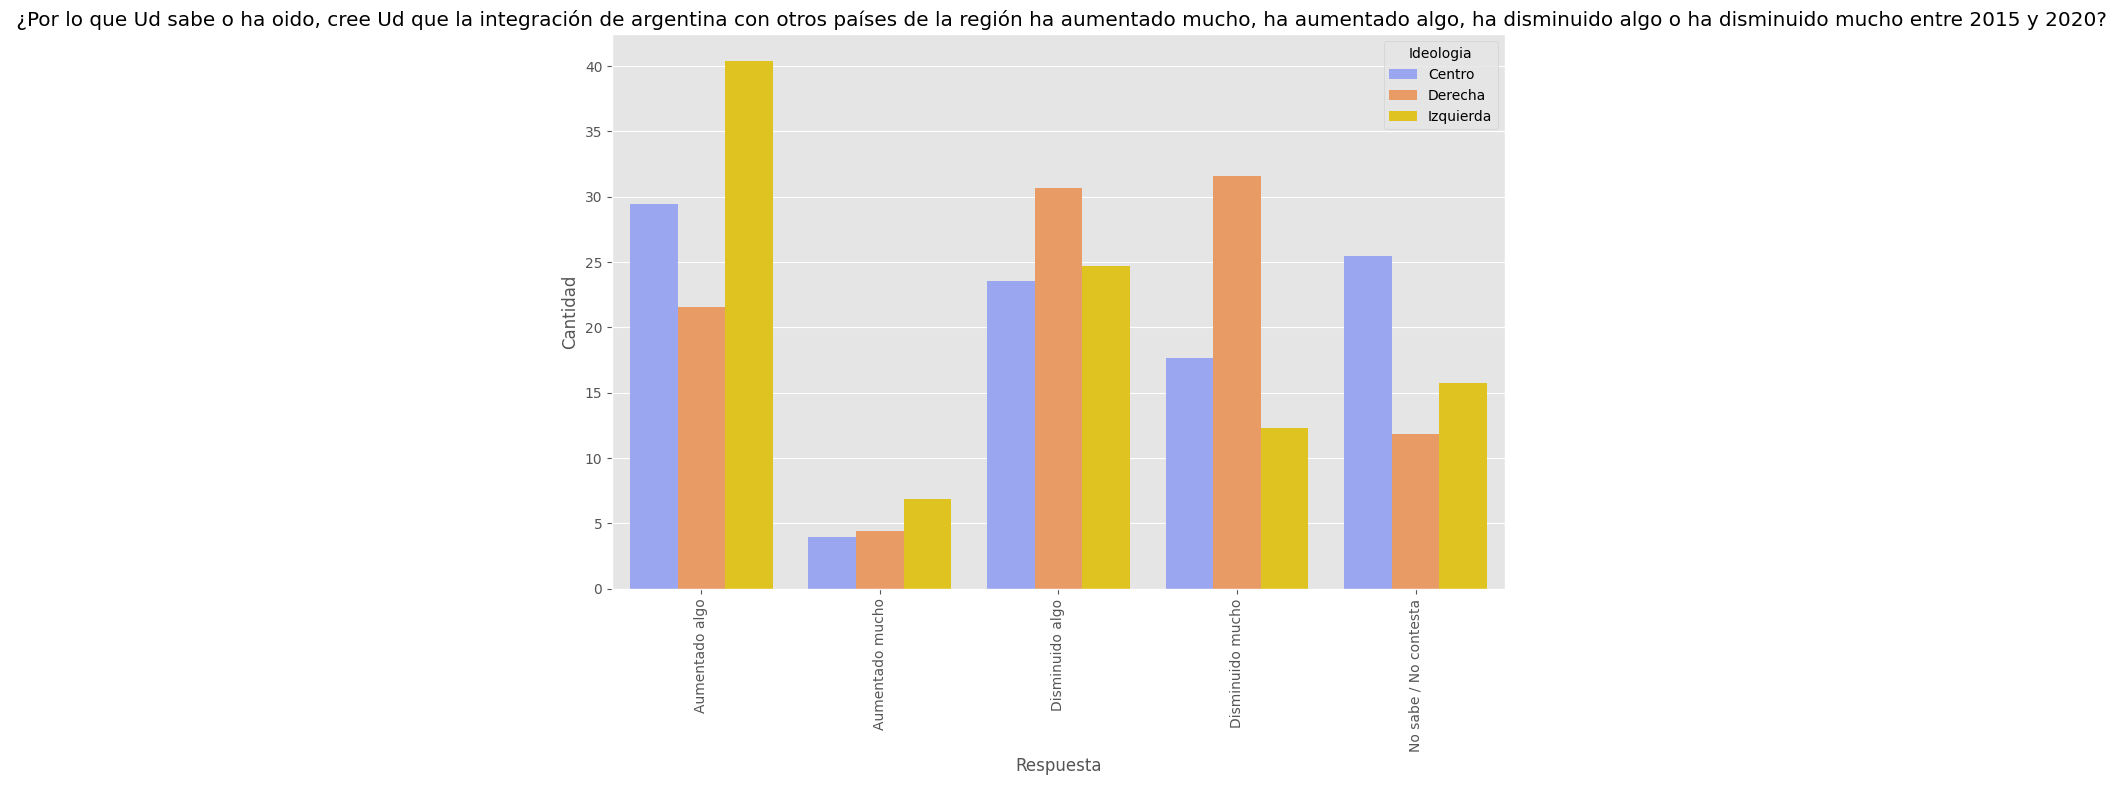

In [44]:
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=100)
occupation_counts = (df_clean.groupby(['Ideologia'])['p25n_text']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('p25n_text'))
p = sns.barplot(x="p25n_text", y="percentage", hue="Ideologia", data=occupation_counts, palette=custom_colors)
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
plt.ylabel("Cantidad")
plt.xlabel("Respuesta")
plt.title(' ¿Por lo que Ud sabe o ha oido, cree Ud que la integración de argentina con otros países de la región ha aumentado mucho, ha aumentado algo, ha disminuido algo o ha disminuido mucho entre 2015 y 2020?')
plt.xticks(rotation=90)
#plt.subplots_adjust(bottom=0.45)
plt.savefig('./outputs/barchart_integracion.png', bbox_inches='tight')
plt.show()

In [45]:
print('¿Que contesto Bard? ',question_convert[bard[bard['Pregunta']=='p5stgbs'.upper()]['Respuesta'].values[0]-1])
print('¿Que contesto GPT? ',question_convert[gpt[gpt['Pregunta']=='p25n'.upper()]['Respuesta'].values[0]])

¿Que contesto Bard?  Disminuido mucho
¿Que contesto GPT?  Aumentado algo


# Propiedad privada

In [46]:
question_convert = reader.value_labels()['P47ST_D'.upper()]
df_clean['p47st_d_text'] = df_clean['p47st_d'].apply(lambda x: question_convert[x])

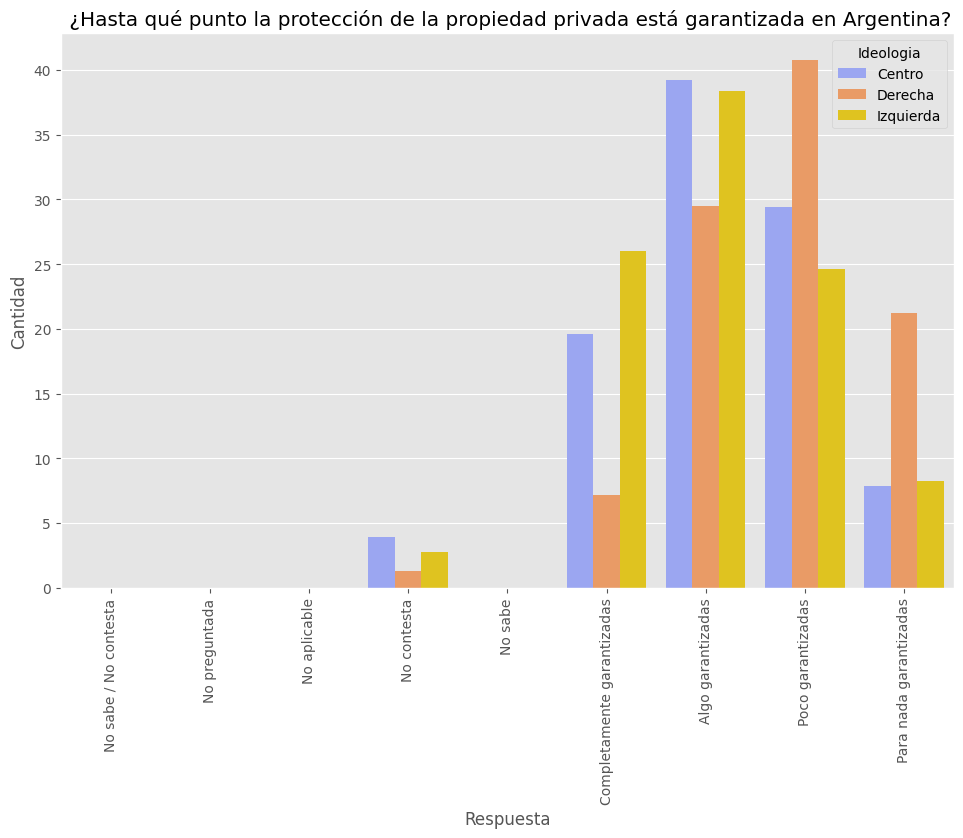

In [47]:
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=100)
occupation_counts = (df_clean.groupby(['Ideologia'])['p47st_d_text']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('p47st_d_text'))
p = sns.barplot(x="p47st_d_text", y="percentage", hue="Ideologia", data=occupation_counts,order=list(reader.value_labels()['P47ST_D'.upper()].values()), palette=custom_colors)
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
plt.ylabel("Cantidad")
plt.xlabel("Respuesta")
plt.title(' ¿Hasta qué punto la protección de la propiedad privada está garantizada en Argentina?')
plt.xticks(rotation=90)
#plt.subplots_adjust(bottom=0.45)
plt.savefig('./outputs/barchart_propiedad_privada.png', bbox_inches='tight')
plt.show()

In [48]:
print('¿Que contesto Bard? ',question_convert[bard[bard['Pregunta']=='p5stgbs'.upper()]['Respuesta'].values[0]-1])
print('¿Que contesto GPT? ',question_convert[gpt[gpt['Pregunta']=='P47ST_D'.upper()]['Respuesta'].values[0]])

¿Que contesto Bard?  Para nada garantizadas
¿Que contesto GPT?  Algo garantizadas


# Género

## Igualdad

In [49]:
def leaning(x):
    if(x < 4):
        return('Izquierda')
    elif(x > 4):
        return('Derecha')
    else:
        return('Centro')

In [50]:
df_clean['sexo_text'] = df_clean['sexo'].apply(lambda x: 'Hombre' if x==1 else 'Mujer')

In [51]:
question_convert = reader.value_labels()['P47ST_F'.upper()]
df_clean['p47st_f_text'] = df_clean['p47st_f'].apply(lambda x: question_convert[x])

In [52]:
responses = list(reader.value_labels()['p47st_f'.upper()].values())
notinlatin = ['No sabe / No contesta',
 'No preguntada',
 'No aplicable','No sabe']
order = [item for item in responses if item not in notinlatin]

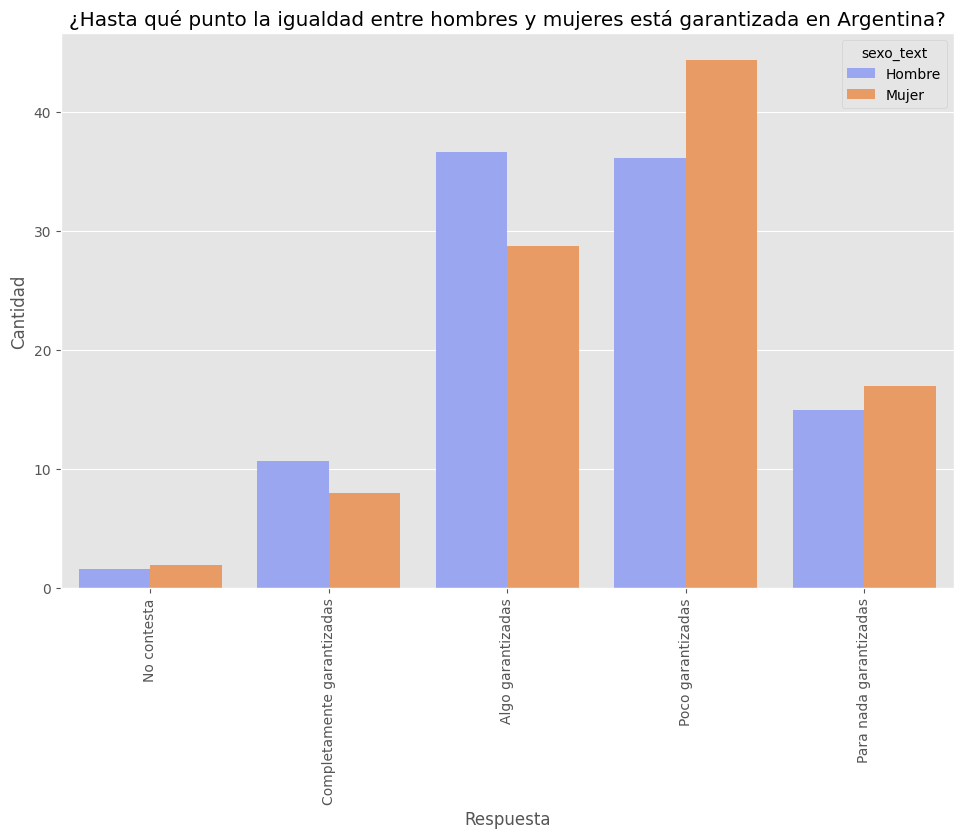

In [53]:
plt.figure(figsize=(6.4 * 1.8, 4.8 * 1.5), dpi=100)
occupation_counts = (df_clean.groupby(['sexo_text'])['p47st_f_text']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('p47st_f_text'))
p = sns.barplot(x="p47st_f_text", y="percentage", hue="sexo_text", data=occupation_counts,order=order, palette=custom_colors)
_ = plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
plt.ylabel("Cantidad")
plt.xlabel("Respuesta")
plt.title('¿Hasta qué punto la igualdad entre hombres y mujeres está garantizada en Argentina?')
plt.xticks(rotation=90)
#plt.subplots_adjust(bottom=0.45)
plt.savefig('./outputs/barchart_grado_genero.png')
plt.show()

In [54]:
print('¿Que contesto Bard? ',question_convert[bard[bard['Pregunta']=='p41n'.upper()]['Respuesta'].values[0]])
print('¿Que contesto GPT? ',question_convert[gpt[gpt['Pregunta']=='p46stgbs'.upper()]['Respuesta'].values[0]])

¿Que contesto Bard?  Poco garantizadas
¿Que contesto GPT?  No contesta
